# Переобучение
Переобучение – это явление, когда качество модели на обучающей выборке существенно превосходит качество модели на тестовой выборке. Я хочу чтобы вы самостоятельно лицезрели как такое может произойти.

В данном ноутбуке с помощью простой сверточной нейросети решается задача CIFAR10. Постановка звучит так: необходимо классифицировать животное на изображении в один из десяти классов - т.е. решается задача мультиклассовой классификации.

In [21]:
import numpy as np

In [22]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

Загрузка датасетов происходит через модуль torchvision.datasets - точно также, как мы уже это делали. Просмотрите код и отметьте для себя - точно ли вы поняли что происходит в этой ячейке? Мы еще не раз будем пользоваться аналогичной загрузкой данных и инициализацией даталоадера, поэтому очень важно понять как это работает.

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cifar_train = datasets.CIFAR10("datasets/cifar10", 
                               download=True, 
                               train=True, 
                               transform=transforms.ToTensor())
cifar_test = datasets.CIFAR10("datasets/cifar10", 
                              download=True, 
                              train=False, 
                              transform=transforms.ToTensor())
train_loader = DataLoader(cifar_train, 
                          batch_size=1024, 
                          shuffle=True, 
                          pin_memory=torch.cuda.is_available())
test_loader = DataLoader(cifar_test,
                         batch_size=1024, 
                         shuffle=False, 
                         pin_memory=torch.cuda.is_available())

Files already downloaded and verified
Files already downloaded and verified


Инициализируем модель - её структура тоже должна быть вам понятна и знакома.

In [24]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1= nn.Sequential(
                nn.Conv2d(3,16, kernel_size=3, padding=1),
                nn.Tanh(),
                nn.MaxPool2d(2),
                )
        self.fc_layer=nn.Sequential(
                nn.Linear(16*16*16, 32),
                nn.Linear(32,10),
                )

    
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(-1, 16*16*16)
        out = self.fc_layer(out)
        return out
        

Обучаем нашу модель - для этого используем ранее созданные dataloaderы.
Давайте обучимся сто эпох и построим графики функции потерь на трейновой выборке и на тестовой.

In [25]:
def train(model, optimizer, epochs=100):
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    test_losses = []
    for i in range(epochs):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = F.cross_entropy(model(X), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Test
        loss_mean = 0 
        elements = 0
        for X, y in iter(test_loader):
            X = X.to(device)
            y = y.to(device)
            loss = F.cross_entropy(model(X), y)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [26]:
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters())
train_l, test_l = train(model, optimizer)

Epoch 0 | Train loss 1.9854375326156617 | Test loss 1.7605503688812256
Epoch 1 | Train loss 1.7020435052108764 | Test loss 1.6438702470779418
Epoch 2 | Train loss 1.60698679397583 | Test loss 1.5600784143447877
Epoch 3 | Train loss 1.5421338606262207 | Test loss 1.5141728160858154
Epoch 4 | Train loss 1.4937854850387573 | Test loss 1.4732265476226807
Epoch 5 | Train loss 1.449743027229309 | Test loss 1.4380926790237427
Epoch 6 | Train loss 1.4116279043197633 | Test loss 1.414355271911621
Epoch 7 | Train loss 1.3761399544906616 | Test loss 1.3808409049987793
Epoch 8 | Train loss 1.347248471221924 | Test loss 1.3557040176391602
Epoch 9 | Train loss 1.3184303826904298 | Test loss 1.339941709136963
Epoch 10 | Train loss 1.2916837404632568 | Test loss 1.3229703262329102
Epoch 11 | Train loss 1.27096394241333 | Test loss 1.3261951868057251
Epoch 12 | Train loss 1.2564479573059082 | Test loss 1.2902288702011109
Epoch 13 | Train loss 1.2352589336013795 | Test loss 1.2797374881744386
Epoch 14 |

Построим график функции потерь

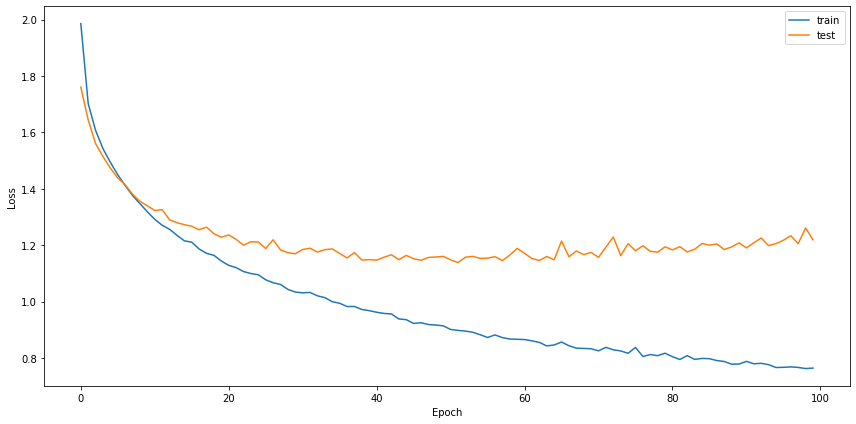

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_l)), train_l, label="train")
plt.plot(range(len(test_l)), test_l, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Dropout
torch.nn.Dropout - это нейросетевой слой который "отключает" часть нейронов во время обучения модели. Его единственный аргумент отвечает за то какую долю нейронов на текущем слое мы отключаем.

In [28]:
class ModelDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1= nn.Sequential(
                nn.Conv2d(3,16, kernel_size=3, padding=1),
                nn.Tanh(),
                nn.MaxPool2d(2),
                nn.Dropout(0.4)
                )
        self.fc_layer=nn.Sequential(
                nn.Linear(16*16*16, 32),
                nn.Dropout(0.4),
                nn.Linear(32,10),
                )

    
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(-1, 16*16*16)
        out = self.fc_layer(out)
        return out


## L2-регуляризация
Член, который добавляется к функции потерь и отвечает за то, чтобы веса модели не принимали слишком большие значения.

В торче такую регуляризацию можно сделать с помощью параметра weight_decay=$\lambda$, задачаемого в оптимизаторе - его величина равна коэффициенту при члене регуляризации в формуле функции потерь (для нашей задачи: лосс = кросс-энтропия + регуляризация = $-\sum_{i=1}^M y_i^{true} \log(y_i^{pred})+\lambda*\sum |w|$, где w - все веса нейронной сети)

In [29]:
model_drop = ModelDropout().to(device)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
train_l, test_l = train(model_drop, optimizer)

Epoch 0 | Train loss 2.0858799657058715 | Test loss 1.900329464149475
Epoch 1 | Train loss 1.8202243697738647 | Test loss 1.7430018716812135
Epoch 2 | Train loss 1.714272763710022 | Test loss 1.6767826824188232
Epoch 3 | Train loss 1.6535722465133667 | Test loss 1.6273089023590088
Epoch 4 | Train loss 1.602025630531311 | Test loss 1.5808920751571656
Epoch 5 | Train loss 1.5623221407318115 | Test loss 1.5415137565612793
Epoch 6 | Train loss 1.5354573793792725 | Test loss 1.5243896265029908
Epoch 7 | Train loss 1.512457173576355 | Test loss 1.5021585206985473
Epoch 8 | Train loss 1.486496940574646 | Test loss 1.485775756072998
Epoch 9 | Train loss 1.4680369645690918 | Test loss 1.5133534832000732
Epoch 10 | Train loss 1.449211210670471 | Test loss 1.4570220352172851
Epoch 11 | Train loss 1.4480867546463012 | Test loss 1.4548245470046997
Epoch 12 | Train loss 1.4257139282226563 | Test loss 1.4515275428771972
Epoch 13 | Train loss 1.419050993385315 | Test loss 1.4430542930603028
Epoch 14 |

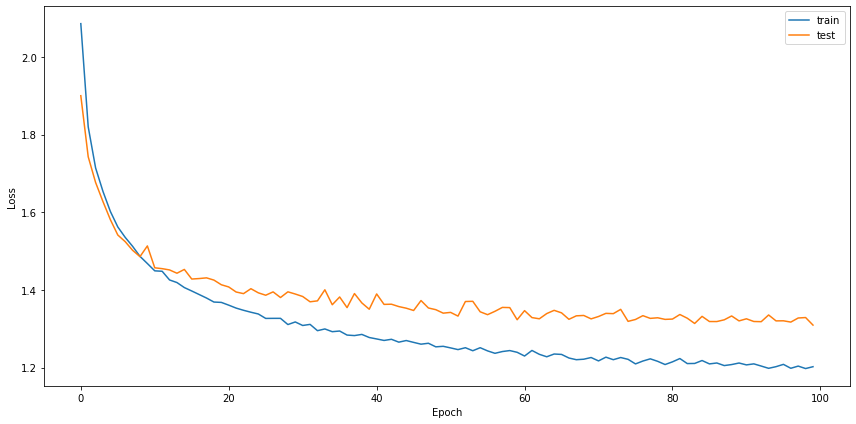

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_l)), train_l, label="train")
plt.plot(range(len(test_l)), test_l, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()